In [6]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy as np

# use which NVIDIA GPU 
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


2024-01-19 11:24:20.525514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-19 11:24:20.525535: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# need load new dataset because the model need the mean and var information
image_size = (72, 64) 
batch_size = 32
data_dir = './data/dataset'
train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                        labels=None, #if label='inferred', data_dir should be structured
                                                        color_mode='rgb', #'grayscale',
                                                        batch_size=batch_size,
                                                        image_size=image_size,
                                                        shuffle=True,
                                                        seed=1,
                                                    #  validation_split=0.2,
                                                    #  subset='both',
                                                        interpolation='lanczos5')    
    
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x: (normalization_layer(x))).prefetch(buffer_size=32) 

Found 430 files belonging to 1 classes.


## Generate new images from pure noise

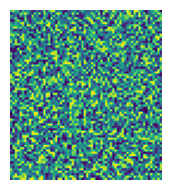

In [8]:
from model import ModelConfig,  DiffusionModel

# using the same paramters as your saved weights.
model_config = ModelConfig(image_size = image_size,
                           batch_size = batch_size)

model = DiffusionModel(model_config) 
model.normalizer.adapt(train_dataset)

checkpoint_path = "checkpoints/diffusion_model"
model.load_weights(checkpoint_path)
# since the model only trained for 10 epochs, the generated image looks very noisy.
model.show_images(num_rows=1, num_cols=1, color_mode='grayscale')

## Add noise to a given image and denoise 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


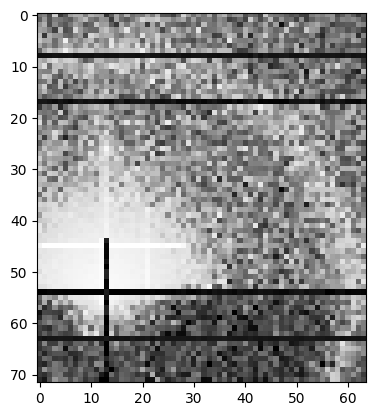

In [9]:
# plot the input image
input_image = next(iter(train_dataset))[1]
plt.imshow(input_image)

scheduler_start_noise level 0.6402579943805379


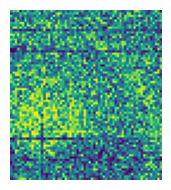

In [10]:
model.generate_images(num_images=1, input_images=input_image, start_noise_percent=0.8, out_path='.')